In [3]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

# ✅ Paths (Update to your dataset path)
DATASET_DIR = r"C:\Users\Dines\OneDrive\Desktop\a\images"
IMG_SIZE = 224  
BATCH_SIZE = 32  

# ✅ Check if dataset exists
if not os.path.exists(DATASET_DIR):
    raise ValueError(f"Dataset directory '{DATASET_DIR}' not found!")

def load_images(folder, label):
    """Loads images from a folder and assigns a label (0 = real, 1 = fake)."""
    images, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Convert BGR to RGB
            images.append(img)
            labels.append(label)
    
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

# ✅ Load images from "real" and "fake" folders
real_images, real_labels = load_images(os.path.join(DATASET_DIR, "real"), label=0)
fake_images, fake_labels = load_images(os.path.join(DATASET_DIR, "fake"), label=1)

# ✅ Combine and shuffle dataset
X = np.concatenate((real_images, fake_images), axis=0)
y = np.concatenate((real_labels, fake_labels), axis=0)
X, y = shuffle(X, y, random_state=42)

# ✅ Normalize images (ResNet expects values in [-1,1] range)
X = (X / 127.5) - 1.0

# ✅ Split into train (80%), val (10%), test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ✅ Convert labels to categorical (for softmax)
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# ✅ Create TensorFlow dataset pipeline
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ✅ Print dataset sizes
print(f"✅ Preprocessing complete! Loaded dataset from '{DATASET_DIR}'")
print(f"Real images: {len(real_images)} | Fake images: {len(fake_images)}")
print(f"Training: {X_train.shape[0]} | Validation: {X_val.shape[0]} | Testing: {X_test.shape[0]}")


✅ Preprocessing complete! Loaded dataset from 'C:\Users\Dines\OneDrive\Desktop\a\images'
Real images: 900 | Fake images: 900
Training: 1440 | Validation: 180 | Testing: 180


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import AdamW


# ✅ Learning rate schedule (Cosine Decay)
def cosine_decay(epoch):
    initial_lr = 0.001
    return float(initial_lr * 0.5 * (1 + tf.math.cos(epoch / 50 * 3.1416)))  # Ensure float output  # 50 epochs

# ✅ ResNet Block
def resnet_block(inputs, filters, kernel_size=3, stride=1):
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=1, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same",
                             kernel_regularizer=regularizers.l2(1e-4))(inputs)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# ✅ ResNet-50 Model
def build_resnet50(input_shape=(224, 224, 3), num_classes=2):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding="same", kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Adding ResNet blocks (50 layers total)
    filter_sizes = [64, 128, 256, 512]
    num_blocks = [3, 4, 6, 3]  # Adjust to reach 50 layers

    for filters, blocks in zip(filter_sizes, num_blocks):
        for i in range(blocks):
            stride = 2 if i == 0 else 1
            x = resnet_block(x, filters, stride=stride)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.6)(x)  # Increase dropout to avoid overfitting
    x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.7)(x)  # Higher dropout to further regularize
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model

# ✅ Compile Model
model = build_resnet50()
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),  # Replacing Lookahead + Adam
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


# ✅ Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = keras.callbacks.LearningRateScheduler(cosine_decay)

# ✅ Model Checkpoint (Save best model when val_loss decreases)
checkpoint_filepath = "resnet50_1_model.h5"
model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor="val_loss", save_best_only=True, verbose=1
)

# ✅ Train Model
history = model.fit(
    train_data, validation_data=val_data, epochs=50,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)

# ✅ Load Best Model & Evaluate
best_model = keras.models.load_model(checkpoint_filepath)
test_loss, test_acc = best_model.evaluate(test_data)

print(f"✅ Best Model Saved at Val Loss: {min(history.history['val_loss']):.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5384 - loss: 2.2462  
Epoch 1: val_loss improved from inf to 2897.44189, saving model to resnet50_1_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5384 - loss: 2.2429 - val_accuracy: 0.4944 - val_loss: 2897.4419 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5855 - loss: 1.8716  
Epoch 2: val_loss improved from 2897.44189 to 228.43680, saving model to resnet50_1_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.5866 - loss: 1.8704 - val_accuracy: 0.5000 - val_loss: 228.4368 - learning_rate: 9.9901e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7774 - loss: 1.6707  
Epoch 3: val_loss did not improve from 228.43680
45/45 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.7771 - loss: 1.6710 - val_accuracy: 0.5611 - val_loss: 431.7307 - learning_rate: 9.9606e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8122 - loss: 1.6097  
Epoch 4: val_loss did not improve from 228.43680
45/45 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8112 - loss: 1.6104 - val_accuracy: 0.5000 - val_loss: 1618.3490 - learning_rate: 9.9114e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8453 - loss: 1.4935  
Epoch 5: val_loss improved from 228.43680 to 27.14484, saving model to resnet50_1_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8458 - loss: 1.4926 - val_accuracy: 0.5111 - val_loss: 27.1448 - learning_rate: 9.8429e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8667 - loss: 1.4743  
Epoch 6: val_loss improved from 27.14484 to 1.34286, saving model to resnet50_1_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8674 - loss: 1.4721 - val_accuracy: 0.8944 - val_loss: 1.3429 - learning_rate: 9.7553e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9519 - loss: 1.2021  
Epoch 7: val_loss did not improve from 1.34286
45/45 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9514 - loss: 1.2033 - val_accuracy: 0.8556 - val_loss: 1.5604 - learning_rate: 9.6489e-04
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9351 - loss: 1.2178  
Epoch 8: val_loss did not improve from 1.34286
45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9355 - loss: 1.2169 - val_accuracy: 0.8056 - val_loss: 1.8188 - learning_rate: 9.5241e-04
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9758 - loss: 1.0947  
Epoch 9: val_loss improved from 1.34286 to 1.16453, saving model to resnet50_1_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9758 - loss: 1.0944 - val_accuracy: 0.9611 - val_loss: 1.1645 - learning_rate: 9.3815e-04
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9930 - loss: 1.0122  
Epoch 10: val_loss did not improve from 1.16453
45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9930 - loss: 1.0121 - val_accuracy: 0.8944 - val_loss: 1.5855 - learning_rate: 9.2216e-04
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8913 - loss: 1.3027  
Epoch 11: val_loss did not improve from 1.16453
45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8906 - loss: 1.3043 - val_accuracy: 0.5000 - val_loss: 418.4318 - learning_rate: 9.0451e-04
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9103 - loss: 1.1547  
Epoch 12: val_loss did not improve from 1.16453
45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9106 - loss: 1.1545 - val_accuracy: 0.4833 - val_loss: 112.2438 - learning_rate: 8.8526e-04
Epoch 13/50
45/45 ━━━━

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9009 - loss: 1.1494 - val_accuracy: 0.9333 - val_loss: 1.0704 - learning_rate: 8.4227e-04
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9630 - loss: 0.9765  
Epoch 15: val_loss improved from 1.07045 to 1.05344, saving model to resnet50_1_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9630 - loss: 0.9763 - val_accuracy: 0.9389 - val_loss: 1.0534 - learning_rate: 8.1871e-04
Epoch 16/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9641 - loss: 0.9647  
Epoch 16: val_loss did not improve from 1.05344
45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9639 - loss: 0.9650 - val_accuracy: 0.8056 - val_loss: 1.6562 - learning_rate: 7.9389e-04
Epoch 17/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9854 - loss: 0.8808  
Epoch 17: val_loss improved from 1.05344 to 0.98083, saving model to resnet50_1_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9854 - loss: 0.8805 - val_accuracy: 0.9722 - val_loss: 0.9808 - learning_rate: 7.6791e-04
Epoch 18/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9787 - loss: 0.8756  
Epoch 18: val_loss did not improve from 0.98083
45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9784 - loss: 0.8764 - val_accuracy: 0.8333 - val_loss: 1.2500 - learning_rate: 7.4088e-04
Epoch 19/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9706 - loss: 0.8792  
Epoch 19: val_loss improved from 0.98083 to 0.92730, saving model to resnet50_1_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9706 - loss: 0.8788 - val_accuracy: 0.9333 - val_loss: 0.9273 - learning_rate: 7.1289e-04
Epoch 20/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9763 - loss: 0.8248  
Epoch 20: val_loss did not improve from 0.92730
45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9763 - loss: 0.8248 - val_accuracy: 0.9000 - val_loss: 1.0913 - learning_rate: 6.8406e-04
Epoch 21/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9885 - loss: 0.7847  
Epoch 21: val_loss improved from 0.92730 to 0.84711, saving model to resnet50_1_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9886 - loss: 0.7845 - val_accuracy: 0.9722 - val_loss: 0.8471 - learning_rate: 6.5451e-04
Epoch 22/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9960 - loss: 0.7515  
Epoch 22: val_loss did not improve from 0.84711
45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9959 - loss: 0.7517 - val_accuracy: 0.9722 - val_loss: 0.8825 - learning_rate: 6.2434e-04
Epoch 23/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9939 - loss: 0.7367  
Epoch 23: val_loss improved from 0.84711 to 0.81580, saving model to resnet50_1_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9939 - loss: 0.7365 - val_accuracy: 0.9722 - val_loss: 0.8158 - learning_rate: 5.9369e-04
Epoch 24/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9992 - loss: 0.7102  
Epoch 24: val_loss improved from 0.81580 to 0.76362, saving model to resnet50_1_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9992 - loss: 0.7102 - val_accuracy: 0.9889 - val_loss: 0.7636 - learning_rate: 5.6266e-04
Epoch 25/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9931 - loss: 0.7192  
Epoch 25: val_loss did not improve from 0.76362
45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9931 - loss: 0.7189 - val_accuracy: 0.8611 - val_loss: 1.0547 - learning_rate: 5.3139e-04
Epoch 26/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9804 - loss: 0.7216  
Epoch 26: val_loss did not improve from 0.76362
45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9805 - loss: 0.7214 - val_accuracy: 0.9500 - val_loss: 0.7837 - learning_rate: 5.0000e-04
Epoch 27/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9980 - loss: 0.6737  
Epoch 27: val_loss improved from 0.76362 to 0.72241, saving model to resnet50_1_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9980 - loss: 0.6735 - val_accuracy: 0.9778 - val_loss: 0.7224 - learning_rate: 4.6860e-04
Epoch 28/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9984 - loss: 0.6563  
Epoch 28: val_loss improved from 0.72241 to 0.71886, saving model to resnet50_1_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9984 - loss: 0.6562 - val_accuracy: 0.9778 - val_loss: 0.7189 - learning_rate: 4.3733e-04
Epoch 29/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.6432  
Epoch 29: val_loss did not improve from 0.71886
45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 1.0000 - loss: 0.6431 - val_accuracy: 0.9722 - val_loss: 0.7275 - learning_rate: 4.0631e-04
Epoch 30/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.6321  
Epoch 30: val_loss did not improve from 0.71886
45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 1.0000 - loss: 0.6320 - val_accuracy: 0.9722 - val_loss: 0.7310 - learning_rate: 3.7565e-04
Epoch 31/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.6225  
Epoch 31: val_loss did not improve from 0.71886
45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 1.0000 - loss: 0.6225 - val_accuracy: 0.9722 - val_loss: 0.7279 - learning_rate: 3.4549e-04
Epoch 32/50
45/45 ━━━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step - accuracy: 0.9529 - loss: 0.7565
✅ Best Model Saved at Val Loss: 0.7189
Test Accuracy: 0.9611


In [6]:
from tensorflow.keras.models import load_model

# ✅ Load the best saved model
model = load_model("resnet50_1_model.h5")

# ✅ Print model summary to confirm it's loaded correctly
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 112, 112, 64)      │           9,472 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 112, 112, 64)      │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 112, 112, 64)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 56, 56, 64)        │               0 │ re_lu[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 28, 28, 64)        │          36,928 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 28, 28, 64)        │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, 28, 28, 64)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 28, 28, 64)        │          36,928 │ re_lu_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 28, 28, 64)        │           4,160 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 28, 28, 64)        │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 28, 28, 64)        │             256 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 28, 28, 64)        │               0 │ batch_normalization_2[0][… │
│                               │                           │                 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_2 (ReLU)                │ (None, 28, 28, 64)        │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 28, 28, 64)        │          36,92

 Total params: 22,501,700 (85.84 MB)

 Trainable params: 22,478,914 (85.75 MB)

 Non-trainable params: 22,784 (89.00 KB)

 Optimizer params: 2 (12.00 B)

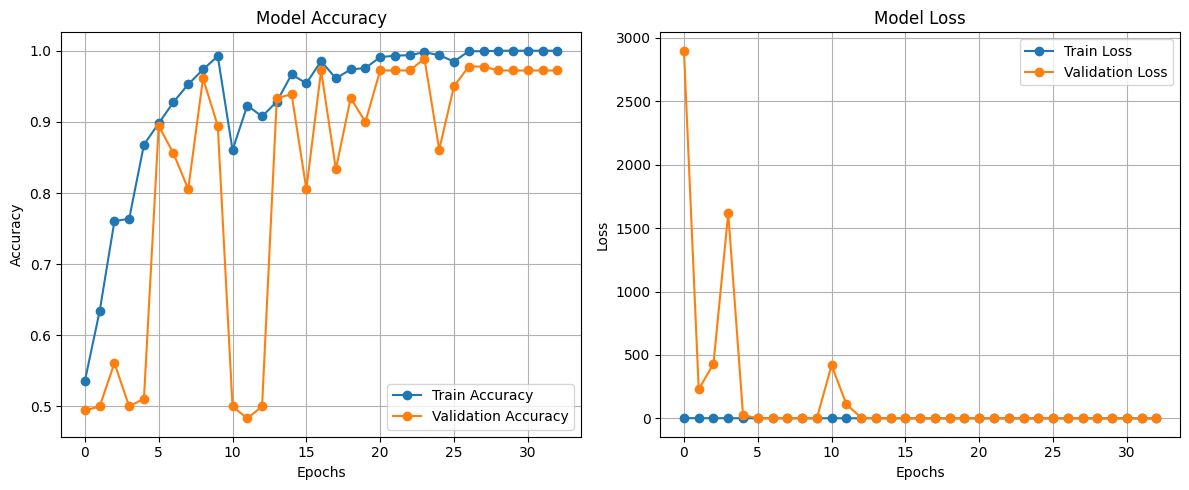

In [7]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plot training & validation accuracy and loss."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # ✅ Accuracy Plot
    ax[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].legend()
    ax[0].grid(True)

    # ✅ Loss Plot
    ax[1].plot(history.history['loss'], label='Train Loss', marker='o')
    ax[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Model Loss')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# ✅ Call function after training
plot_training_history(history)


📊 Classification Report:
               precision    recall  f1-score   support

        Real       0.97      0.96      0.96        90
        Fake       0.96      0.97      0.96        90

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180



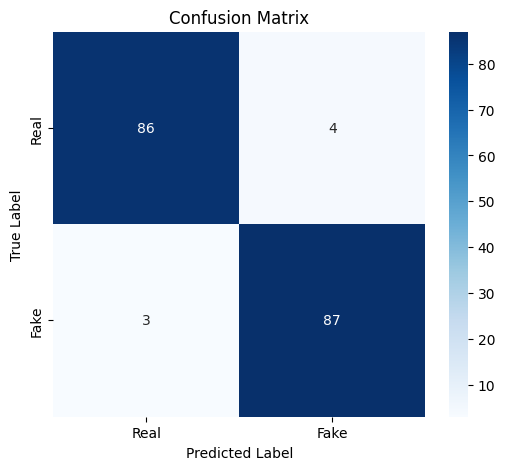

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are the actual and predicted labels
# Ensure y_test and y_pred are 1D arrays with single-label classification
if len(y_test.shape) > 1:  # In case they are multilabel
    y_test = np.argmax(y_test, axis=1)
if len(y_pred.shape) > 1:  # In case predictions are multilabel
    y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print("📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [2]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

# ✅ Load the trained ResNet50 model
MODEL_PATH = "resnet50_1_model.h5"  # Update to ResNet50 model path
model = load_model(MODEL_PATH, compile=False)

# ResNet50 expects 224x224x3 input
IMG_SIZE = 224  
CHANNELS = 3    

# ✅ Function to preprocess a single image
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise ValueError(f"❌ Image not found: {image_path}")

    img = cv2.imread(image_path)  # Load image
    if img is None:
        raise ValueError(f"❌ Unable to load image: {image_path}")

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (ResNet50 expects RGB)
    img = img / 255.0  # Normalize pixel values to [0,1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# ✅ Function to make a prediction
def predict_image(image_path):
    try:
        img = preprocess_image(image_path)  # Preprocess input image
        prediction = model.predict(img)[0]  # Get prediction probabilities
        
        class_names = ["✅ Real CT Scan (Class 0)", "❌ Fake CT Scan (Class 1)"]
        predicted_class = np.argmax(prediction)  # Get class with highest probability
        confidence = prediction[predicted_class] * 100  # Convert to percentage
        
        print(f"Prediction: {confidence:.2f}% → {class_names[predicted_class]}")
    
    except Exception as e:
        print(f"⚠️ Error: {e}")

# ✅ Example usage
IMAGE_PATH = r"C:\Users\uppal\OneDrive\Desktop\DL\f2.png"  # Change this to your test image path
predict_image(IMAGE_PATH)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: 60.72% → ❌ Fake CT Scan (Class 1)
